In [1]:
#importing the dataset
import csv
with open('transcripts.csv', encoding='latin-1') as TED_transcript:
    transcript_csv = csv.reader(TED_transcript)
    next(transcript_csv)
    transcripts = list(transcript_csv)
    
#Converting the csv file to a list of strings (get rid of the url) and eliminating the second column
transcript_data: list[str] = [t[0] for t in transcripts]
#Sanity check
#print(type(transcript_data)) prints out list

In [2]:
#Preprocessing the data and Corpus Creation
import re
import inflect
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

p = inflect.engine()
stop_words: set[str] = set(stopwords.words("english"))

def preprocess_text_list(text_list):
    """
    Preprocesses text in a list of string
    Args:
        text_list(list[str]): a list of string

    Returns:
        processed_text(list[list(str)])): a list of string preprocessed for concatenation into a single corpus
    """
    processed_text = []
    for text in text_list:
        #use re.sub to get rid pf punctuations and replace hem with whitespace
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        #tokenize the words
        tokens = word_tokenize(text)
        
        #get rid fo stop words using NLTK's stop word list and convert numbers('10') into words ('ten')
        filtered  = []
        for word in tokens:
            word_lower = word.lower()
            if word_lower.isdigit():
                word_lower = p.number_to_words(word_lower)
            if word_lower not in stop_words:
                filtered.append(word_lower)
        
        #append the filtered words to the list
        processed_text.append(filtered)
    return processed_text

#creates a list of list of tokenized words
preprocessed_corpus: list[list[str]] = preprocess_text_list(transcript_data)


In [3]:
#SANITY CHECK THIS IS OPTIONAL 
print("SANITY CHECK!!!!")
print(f"Type of corpus: {type(preprocessed_corpus)}")
print(f"Type of first element: {type(preprocessed_corpus[0])}")
print(f"Number of sentences: {len(preprocessed_corpus)}")
print(f"First 2 sentences:")
for i, sentence in enumerate(preprocessed_corpus[:2]):
    print(f"  Sentence {i}: {sentence[:8]}...")  # First 8 words


SANITY CHECK!!!!
Type of corpus: <class 'list'>
Type of first element: <class 'list'>
Number of sentences: 2467
First 2 sentences:
  Sentence 0: ['good', 'morning', 'laughter', 'great', 'blown', 'away', 'whole', 'thing']...
  Sentence 1: ['thank', 'much', 'chris', 'truly', 'great', 'honor', 'opportunity', 'come']...


In [4]:
#Word2Vec (using Logistic regression) - Turn it into a class since there seems to be a lot going on from the textbook
import numpy as np
from collections import Counter

#This for the randomization
np.random.seed(42)

class word2vec:
    #initialize the embedding dimension, window size, negative samples, learning rate, minimium count of word, and number of epochs
    def __init__(self, embedding_dim = 100, window_size = 5, negative_samples = 10, learning_rate = 0.025, min_count = 1, epoch = 10):
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.negative_samples = negative_samples
        self.learning_rate = learning_rate
        self.min_count = min_count
        self.epochs = epoch
        
        #Training variables (originally None (set during the training corpus))
        self.vocab = None 
        self.word_to_index = None 
        self.index_to_word = None
        self.W_input = None
        self.W_output = None
        self.noise_words = None
        self.noise_prob = None
        
    def build_vocabulary(self, corpus:list[list[str]]):
        """
        Builds the vocabulary of the corpus (index words and count the frequency of the words)
        Args:
            corpus (list[list[str]]): a list of list of strings containing tokenized text of ted talk transcripts
        """
        word_count = Counter()
        #Count every word that appears in a sentence in the corpus of transcripts
        for sentence in corpus:
            for word in sentence:
                word_count[word] += 1
        
        #Get the vocab of the corpus (even though min_count is 1, still need to handle empty words)
        self.vocab = [word for word, count in word_count.items() if count >= self.min_count]
        self.vocab_size = len(self.vocab)
        #Create a mapping of words (index to a word, word to an index)
        self.word_to_index = {word: index for index, word in enumerate(self.vocab)}
        self.index_to_word = {index: word for index, word in enumerate(self.vocab)}
        self.word_freq = {word: word_count[word] for word in self.vocab}
        
    def compute_noise_distribution(self):
        """Compute the noise distribution for the words (negative sampling)"""
        #Get the sum of the word frequencies
        total = sum(self.word_freq.values())
        
        #Create a dictionary of noise distribution to each word
        noise_distribution = {}
        
        #This is from 6.8.2 Learn skip-gram embeddings (page 124-125)
        for word in self.vocab:
            prob = (self.word_freq[word]/total) ** 0.75
            noise_distribution[word] = prob
            
        #Normalize the distribution
        total_prob = sum(noise_distribution.values()) #Total probability
        self.noise_words = list(noise_distribution.keys()) #A list of words from the nosie distribution dictionary
        self.noise_prob = [prob/total_prob for prob in noise_distribution.values()] #The probability for each word/total probability
    
    def init_embeddings(self):
        """Initializing the embedding matrices (input and output)
        """
        limit = 0.5/self.embedding_dim #Small values to avoid saturation
        self.W_input = np.random.uniform(-limit, limit, (self.vocab_size, self.embedding_dim))
        self.W_output = np.random.uniform(-limit, limit, (self.vocab_size, self.embedding_dim))
    
    def sigmoid(self, x:np.array):
        """
        The sigmoid function of logistic regression (neceassary for word2vec)
        Args:
            x (ndarray): numpy array of dot product of the target word and the context word

        Returns:
            the sigmoid function of x 
        """
        #Might have large and negative values(ADD LATER IF THAT OCCURS!!)
        return 1/(1 + np.exp(-x))
    
    def negative_sample(self):
        """sample negative word"""
        return np.random.choice(self.noise_words, p=self.noise_prob)
    
    def get_context_words(self, sentence:list[str], center_pos):
        #get the context words from the corpus
        
        """
        Args:
            sentence (list[str]) : a list containing the target words and context words
        Returns:
            context (list): a list containing the context words that surround the target word in a sentence
        """
        context = []
        #Get the 5 words before the context word
        start = max(0, center_pos - self.window_size)
        #Get the 5 words after the context word
        end = min(len(sentence), center_pos + self.window_size + 1)
        
        for pos in range(start,end):
            #If the position is not in the center position and the word is in the vocabulary (within the index))
            if pos != center_pos and sentence[pos] in self.word_to_index:
                #Add the word to the context list
                context.append(sentence[pos])
        
        return context
    
    def update_embeddings(self, center_word:str, context_word:str, label:int):
        """
        Update the embeddings for one pair of words
        Args:
            center_word (string): the center/target word in the sentence
            context_word (string):the word surrounding the center/target word
            label (int): the groundtruth of the word pairings
        
        Return
            error ** 2
        """
        #Get the index of the center word and the context word
        center_index = self.word_to_index[center_word]
        context_index = self.word_to_index[context_word]
        
        #create the vectors for the dot product
        v_center = self.W_input[center_index] #vector for the center/target word
        u_context = self.W_output[context_index] #vector for the context word
        
        dot_product = np.dot(v_center, u_context)
        prediction = self.sigmoid(dot_product)
        error = label - prediction
        
        #Update the embedding matrices
        self.W_input[center_index] = self.W_input[center_index] + self.learning_rate * error * u_context
        self.W_output[context_index] = self.W_output[context_index] + self.learning_rate * error * v_center
        
        return error ** 2
    
    def train(self, corpus:list[list[str]]):
        """
        This function trains the model using the corpus created in the previous cell
        Args:
            corpus (list[list[str]]): The entire tokenized ted talk transcripts
        """
        #Build the vocabulary from the corpus
        self.build_vocabulary(corpus)
        
        #Compute the noise distribution for the words
        self.compute_noise_distribution()
        
        #initialize the embedding matrices
        self.init_embeddings()
        
        #All the losses during the training
        losses = []
        
        for epoch in range(self.epochs):
            #total loss during the epoch training
            total_loss = 0
            pairs = 0
            
            #Look at eahc sentence in the corpus
            for sentence in corpus:
                #Look for the center word and center position in the sentence
                for center_pos, center_word in enumerate(sentence):
                    #If that word isn not in the vocab
                    if center_pos not in self.word_to_index:
                        continue #Skip to the next iteration
                
                    context_words = self.get_context_words(sentence, center_pos) #get the context words in the sentecne

                    #Positive samples (context words)
                    for context_word in context_words:
                        loss = self.update_embeddings(center_word, context_word, 1) #Make it 1 bc they're a pair
                        total_loss += loss
                        pairs += 1
                        
                    #Negative samples (random words in the lexicon)
                    for _ in range(self.negative_samples):
                        #Grab a negative word from the negative sample function
                        negative_word = self.negative_sample()
                        
                        #Make sure the negative word chosen at random is not the context word
                        if negative_word != context_word:
                            loss = self.update_embeddings(center_word, negative_word, 0) #make it 0 bc the two don't appear together
                            total_loss += loss
                            pairs += 1
                            
            avg_loss = total_loss/pairs if pairs > 0 else 0 #get the average loss (total loss divided by number of pairs(if pairs > 0))
            losses.append(avg_loss) #append the average loss to the list of losses
            
            #Decay the learning rate
            self.learning_rate *= 0.99
        
        #Return everything for word2vec analysis (Include word index and index to word for sanity check)
        return {
            'word_vectors': self.W_input,
            'vocabulary': self.vocab,
            'word_to_index': self.word_to_index,
            'index_to_word': self.index_to_word,
            'training_losses': losses
        }
        
    # Added this to get the vector of a certain word (Didn't have this originally)
    def get_vector(self, word):
        """
        A helper function to get the vector of a word for cosine similarity
        """
        if word in self.word_to_index:
            return self.W_input[self.word_to_index[word]]
        return None
            

In [5]:
#PPMI
from collections import defaultdict
import numpy as np
import math
#Co-occurence matrix creation
def create_cooccurence_matrix(corpus: list[list[str]], window_size = 5):
    """
    Creates a co-occurrence matrix from the corpus with a default window size of 5
    Args:
        sentence (list[str]): a list of strings 
        window_size (int, optional): The size of the context window around each word. Defaults to 5.
        
    Returns
        cooccurrence_matrix (np.array): a  2D co-occurrence matrix of all the words in the corpus
        vocab (lis[str]): a list of all the words in the corpus
        word_to_index (dict): a dictionary mapping every word to matrix index
    """
    #Create a default dictionary of word countds
    word_counts = defaultdict(int)
    for sentence in corpus:
        for word in sentence:
            word_counts[word] += 1
    
    #Make a sorted list of words from the word_counts
    vocab = sorted(word_counts.keys())
    #Map every word to an index in the vocab list
    word_to_index = {word: index for index, word in enumerate(vocab)}
    #Make a voacb size for the co-occurrence matrix
    vocab_size = len(vocab)
    
    #Initialize an empty co-occurrence matrix (make it the the size of the vocab (32 int to be safe))
    cooccurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    #Fill in the co-occurence matrix with the words in the corpus
    for sentence in corpus:
        #Look for the center word in the sentenxe
        for center_pos, center_word in enumerate(sentence):
            #If it's not there, then skip and go to the next one
            if center_word not in word_to_index:
                continue
            center_index = word_to_index[center_word]
            
            #Start with the max of 0 or the center position - the window size defined above
            start = max(0, center_pos - window_size)
            #End with the minimum of the sentence length or the center position + window size + 1
            end = min(len(sentence), center_pos + window_size + 1)
            
            for context_pos in range(start,end):
                #Check to see if the context word is the center/target word
                if context_pos == center_pos:
                    continue
                
                #Check to see if the context word is in the word_to_index
                context_word = sentence[context_pos]
                if context_word not in word_to_index:
                    continue #Skip if it's not in the word_to_index
                
                context_index = word_to_index[context_word]
                
                #Symmetric co-occurrence (both directions need to be +1)
                cooccurrence_matrix[center_index, context_index] += 1
                cooccurrence_matrix[context_index, center_index] += 1
                
    return cooccurrence_matrix, word_to_index

def pmi(cooccurence_matrix: np.array, smoothing = 0.1):
    """
    This computes the pointwise mutual information of the corpus
    
    Arguments:
        cooccurrence_matrix(np.array): a  2D co-occurrence matrix of all the words in the corpus
        smoothing(float, optional): Smoothing factor to avoid the log(0)
    Returns:
        pmi_matrix: a 2D numpy array holding all the pointwise mutual information of the corpus words
    """
    vocab_size = cooccurence_matrix.shape[0]
    
    #smooth the matrix to avoid zero division (make it into a float to add the smoothing)
    smoothed_matrix = cooccurence_matrix.astype(np.float64) + smoothing
    
    #compute the total co-occurrences
    total_cooccurrences = np.sum(smoothed_matrix)
    
    #Get the joint probability P(word_i, word_j)
    Prob_joint = smoothed_matrix/total_cooccurrences
    
    #Get the marginal probabilities (P(word_i) and P(word_j))
    P_row = np.sum(Prob_joint,axis=1) #P(word_i)
    P_col = np.sum(Prob_joint,axis=0) #P(word_j)
    
    #Initialize the pmi matrix with vocab_size
    pmi_matrix = np.zeros((vocab_size, vocab_size))
    
    #Go through the vocab size
    for i in range(vocab_size):
        for j in range(vocab_size):
            if cooccurence_matrix[i,j] > 0: #Look for word that actually co-occur
                #Get the joint probability of word i and j
                joint_prob = Prob_joint[i,j]
                #Get the product of the marginal probabilities
                marginal_product = P_row[i] * P_col[j]
                
                #If the marginal product > 0, add the log(joint porbability/marginal_product) to the pmi_matrix
                #Otherwise, the pmi_value is 0 for word i and j
                if marginal_product > 0:
                    pmi_value = math.log(joint_prob/marginal_product)
                    pmi_matrix[i,j] = pmi_value
                    
    return pmi_matrix
def ppmi(pmi_matrix):
    """
    This compute the positive pointwise mutual information of the corpus (taking information from pmi)
    
    Arguments:
        pmi_matrix(np.array): a 2D numpy array containing the pmi_values for words that co-occur in the co-occurrence matrix
        
        Returns:
        ppmi_matrix(np.array): a 2D numpy array with negative PMI values set to 0
    """
    ppmi_matrix = np.maximum(0,pmi_matrix)
    
    return ppmi_matrix

    

In [6]:
#TF-IDF
import math
from collections import Counter

def term_frequency(sentence: list[str]):
    """
    Returns the term frequency in a document
    Args:
        sentence (list[str]): the document where the word frequency is counted

    Returns:
        tf_dict (dictionary): a dictionary that has the word as the key and the times it appears in the document/sentence  as a value
    """
    total_terms = len(sentence)
    term_counts = Counter(sentence)
    
    tf_dict = {}
    for word, count in term_counts.items():
        tf_dict[word] = count/total_terms
        
    return tf_dict

def inverse_doc_freq(doc_freq, corpus: list[list[str]]):
    """Returns the inverse document frequency
    
    Args:
        doc_freq (dictionary): a dictionary that contains the word and the number of documents the word appears in
        corpus (list[list[str]]): this is the entire corpus containing all the transcripts
    
    Returns:
    
    idf_scores (dictionary): a dictionary of word to its idf score
    """
    idf_scores = {} #Creating a dictionary
    total_docs = len(corpus) #This is because we want to have the total number of documents
    for word, freq in doc_freq.items():
        idf = math.log(total_docs/ (freq +1))
        idf_scores[word] = idf
        
    return idf_scores

def compute_document_frequency(corpus:list[list[str]]):
    """
    A helper function to count how many documents contain each word
    
    Args:
        corpus (list[list[str]]): the entire corpus/transcripts

    Returns:
        doc_freq(Counter): a counter that has every word in each document
    """
    doc_freq = Counter()
    
    #iterate through every document in the corpus
    for document in corpus:
        
        #We don't want to count the same word over and over again, so make it a set since it doesn't contain duplicates
        unique_word = set(document)
        #Adds the number of counts in the document frequency counter
        doc_freq.update(unique_word)
        
    return doc_freq

def tfidf(corpus:list[list[str]]):
    """ 
    This computes the entire tf-idf of the corpus
    Args:
    
    Returns:
    A TF-IDF matrix representing each word's importance to the entire corpus
    """
    #Make a vocab set
    vocab = set()
    
    for document in corpus:
        vocab.update(document)
    vocab = sorted(vocab)
    
    #Get the document frequency fomr the corpus
    doc_freq = compute_document_frequency(corpus)
    
    #Get the idf scores using doc_freq and corpus
    idf_scores = inverse_doc_freq(doc_freq, corpus)
    
    #creating a matrix to hold the tf-idf of eveyr word in the corpus
    tfidf_matrix = []
    
    for document in corpus:
        
        #Get the term frequency score of each document
        tf_scores = term_frequency(document)
        
        #Compute the tfidf for every word in the corpus
        doc_tfidf = {}
        for word in vocab:
            if word in tf_scores:
                
                #TF-IDF = TF(word) * IDF(word)
                doc_tfidf[word] = tf_scores[word] * idf_scores[word]
                
            else:
                #If the word doesn't appear, make it 0
                doc_tfidf[word] = 0
    
        tfidf_matrix.append(doc_tfidf)
    
    return tfidf_matrix


In [7]:
#Actually train the models

#Word2vec
word2vec_model = word2vec(embedding_dim=100,window_size=5,negative_samples=10, learning_rate=0.025, min_count=1, epoch=30)
word2vec_results = word2vec_model.train(preprocessed_corpus)

#PPMI
co_occurrence_matrix, word_to_idx = create_cooccurence_matrix(preprocessed_corpus)
pmi_matrix = pmi(co_occurrence_matrix, smoothing=0.1)
ppmi_matrix = ppmi(pmi_matrix)

#TF-IDF
tfidf_matrix = tfidf(preprocessed_corpus)


In [8]:
#Select word pairs
word_pair1 = [("technology", "innovation"), ("learning", "fun")]
word_pair2 = [("future", "artificial"),("intelligence", "machine")]


In [9]:
#Cosine similarity
def word2vec_cosine_similarity(model, word1, word2):
    """
    A function to compute the cosine similarity of word pairs
    """
    vec1 = model.get_vector(word1)
    vec2 = model.get_vector(word2)
    
    #If the function returns None for either vector 1 or vector 2, return None
    if vec1 is None or vec2 is None:
        return None
    
    #calculate the dot product
    dot_product = np.dot(vec1, vec2)
    
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    #Cosine similarity = dot product of vector 1 and vector 2  /(Norm vector 1 * norm vector 2)
    if norm1 > 0 and norm2 > 0:
        return dot_product/(norm1 * norm2)
    else:
        return 0.0
    
def ppmi_cosine_similarity(ppmi_matrix, word_to_index, word1, word2):
    
    #If either word can't be found, then the vector doesn't exist so return None
    if word1 not in word_to_index or word2 not in word_to_index:
        return None
    
    index1 = word_to_index[word1]
    index2 = word_to_index[word2]
    
    #Get the PPMI vectors for both words
    vec1 = ppmi_matrix[index1, :] #Row for word 1 (forgot to put the , between index and : so it assumed a bigger dimension)
    vec2 = ppmi_matrix[index2, :] #Row for word 2
    
    #calculate the dot product of the two vectors
    dot_product = np.dot(vec1, vec2)
    
    #This is the numpy linear algebra function to get the vector norm of vector 1 and vector 2
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    #If the norm of vector1 and vector2 are greater than 0, return (dot product/(||vector1|| * ||vector2||))
    #Otherwise, return 0
    if norm1 > 0 and norm2 > 0:
        return dot_product / (norm1 * norm2)
    else:
        return 0.0
    
def tfidf_cosine_similarity(tfidf_matrix, word1, word2):
    # Create vectors representing each word's TF-IDF across all documents
    vec1 = np.array([doc.get(word1, 0.0) for doc in tfidf_matrix])
    vec2 = np.array([doc.get(word2, 0.0) for doc in tfidf_matrix])
    
    # Cosine similarity
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    if norm1 > 0 and norm2 > 0:
        return dot_product / (norm1 * norm2)
    else:
        return 0.0

In [10]:
def compare_all_model_similarities(word_pairs, word2vec_model, ppmi_matrix, ppmi_word_to_index, 
                                   tfidf_matrix) -> dict:
    
    #Initialize a dictionary that holds the cosine similarity results for all the models
    results = {}
    #For every two words in the word_pairs
    for word1, word2 in word_pairs:
        
        #Calculate the word2vec cosine similarity
        w2v_sim = word2vec_cosine_similarity(word2vec_model, word1, word2)
        
        #Calculate the ppmi matrix cosine similarity
        ppmi_sim = ppmi_cosine_similarity(ppmi_matrix, ppmi_word_to_index, word1, word2)
        
        #Calculate the tfidf matrix cosine similarity
        tfidf_sim = tfidf_cosine_similarity(tfidf_matrix, word1, word2)
        
        results[(word1, word2)] = {
            'word2vec': w2v_sim if w2v_sim is not None else 0.0,
            'ppmi': ppmi_sim if ppmi_sim is not None else 0.0,
            'tfidf': tfidf_sim
        }
    return results

word_pair_result1 = compare_all_model_similarities(word_pair1,word2vec_model, ppmi_matrix,word_to_idx, tfidf_matrix)
word_pair_result2 = compare_all_model_similarities(word_pair2,word2vec_model, pmi_matrix,word_to_idx, tfidf_matrix)


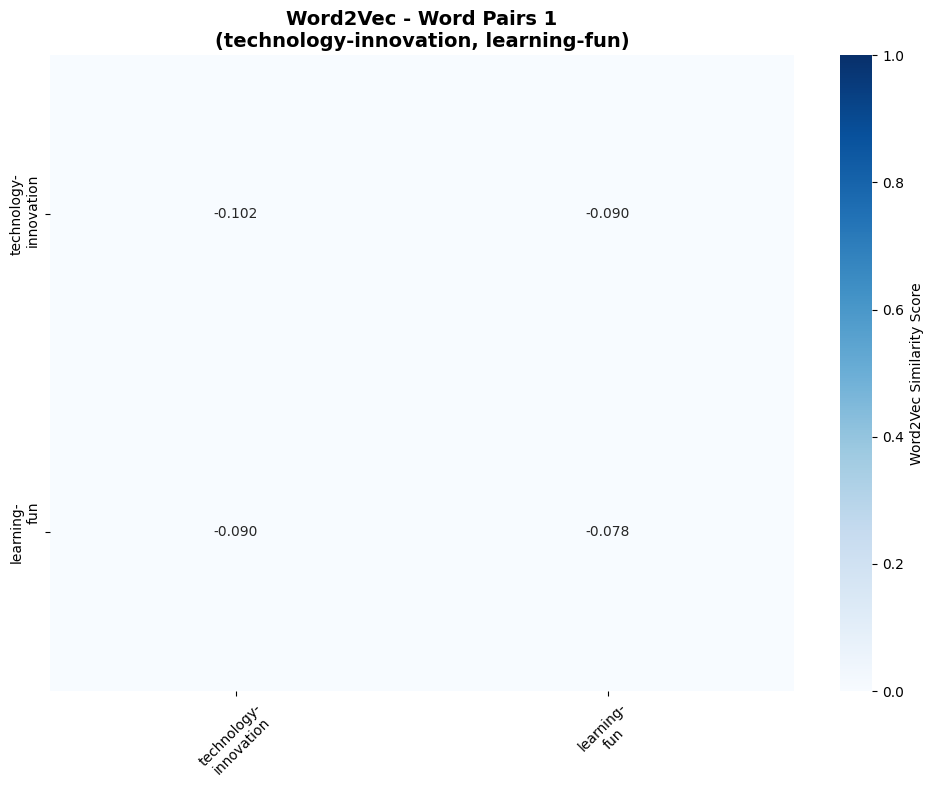

In [13]:
#Heatmap Analysis for word2vec
import seaborn as sns
import matplotlib.pyplot as plt

#Get the word pairs from both result 1 and result 2
word_pairs1 = list(word_pair_result1.keys())

#Extract the word2vec similarities from the list of word pairs (1 and 2)
word2vec_wordpair1_similarity = [word_pair_result1[pair]['word2vec'] for pair in word_pairs1]

#create word2_vec_similarity matrices for word pairs 1 and 2 (initialize it with 0s)
similarity_matrix1 = np.zeros((len(word_pairs1), len(word_pairs1))) #Specifically focus on the words from word_pairs1

#Add the word2vec similarities from word_pairs1
for i in range(len(word_pairs1)):
    for j in range(len(word_pairs1)):
        #This is for the diagonal elements [0,0] = 0
        if i == j:
            similarity_matrix1[i,j] = word2vec_wordpair1_similarity[i]
        #Off-diagonal elements [0,1]
        else:
            similarity_matrix1[i,j] = (word2vec_wordpair1_similarity[i] + word2vec_wordpair1_similarity[j])/2

#Create the heapmap for word pairs 1
plt.figure(figsize=(10,8))
pair_labels1 = [f"{w1}-\n{w2}" for w1, w2 in word_pairs1]
sns.heatmap(similarity_matrix1,
            xticklabels=pair_labels1,
            yticklabels=pair_labels1,
            annot=True,
            fmt='.3f',
            cmap='Blues',
            cbar_kws={'label': 'Word2Vec Similarity Score'},
            vmin=0, vmax=1)
plt.title('Word2Vec - Word Pairs 1\n(technology-innovation, learning-fun)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    

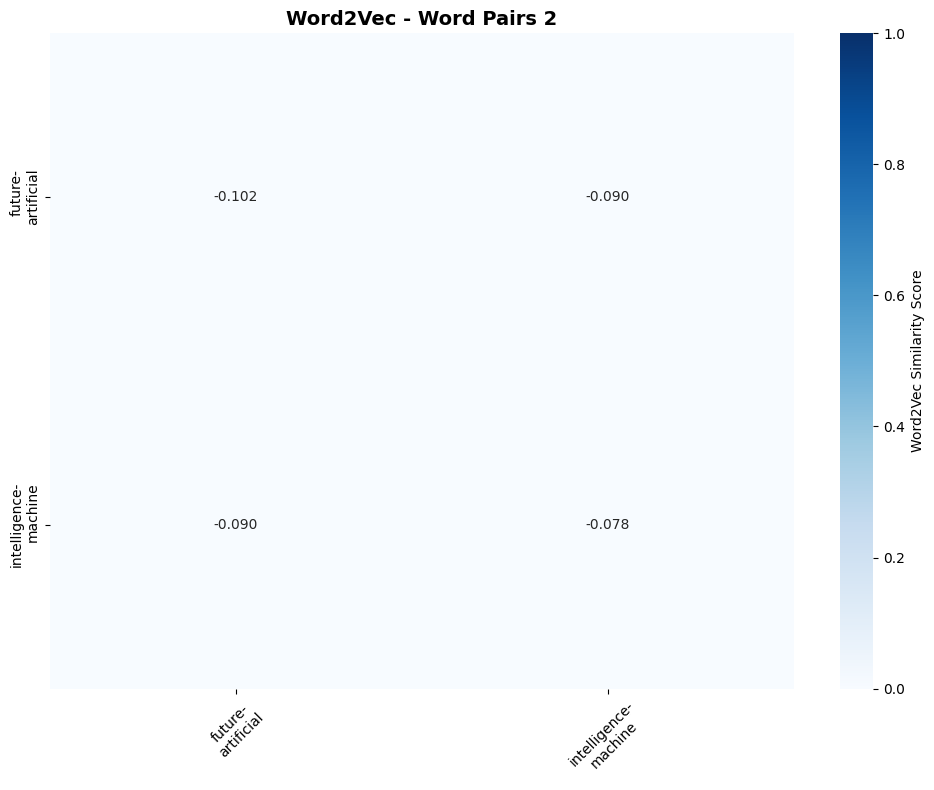

In [21]:
#create the heatmap for word pairs 2
word_pairs2 = list(word_pair_result2.keys())

word2vec_wordpair2_similarity =[word_pair_result2[pair]['word2vec'] for pair in word_pairs2]

#Create a similarity matrix for word pairs 2
similarity_matrix2 = np.zeros((len(word_pairs2), len(word_pairs2))) #Specifically focus on the words from word_pairs2

#Add the word2vec similarities from word_pairs2
for i in range(len(word_pairs2)):
    for j in range(len(word_pairs2)):
        if i == j:
            similarity_matrix2[i,j] = word2vec_wordpair2_similarity[i]
        else:
            similarity_matrix2[i,j] = (word2vec_wordpair2_similarity[i] + word2vec_wordpair2_similarity[j]) /2

#Create the heapmap for word pairs 2
plt.figure(figsize=(10,8))
pair_labels2 = [f"{w1}-\n{w2}" for w1, w2 in word_pairs2]
sns.heatmap(similarity_matrix1,
            xticklabels=pair_labels2,
            yticklabels=pair_labels2,
            annot=True,
            fmt='.3f',
            cmap='Blues',
            cbar_kws={'label': 'Word2Vec Similarity Score'},
            vmin=0, vmax=1)
plt.title('Word2Vec - Word Pairs 2', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

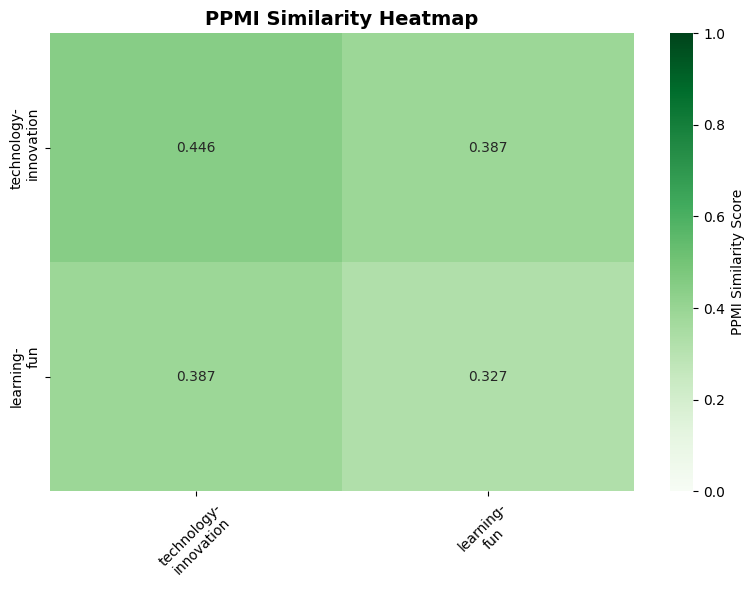

In [ ]:
#Heatmap Analysis for PPMI
ppmi_similarities = [word_pair_result1[pair]['ppmi'] for pair in word_pairs1]

similarity_matrix = np.zeros((len(word_pairs1), len(word_pairs1)))
for i in range(len(word_pairs1)):
    for j in range(len(word_pairs1)):
        if i == j:
            similarity_matrix[i, j] = ppmi_similarities[i]
        else:
            similarity_matrix[i, j] = (ppmi_similarities[i] + ppmi_similarities[j]) / 2

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix,
            xticklabels=pair_labels1,
            yticklabels=pair_labels1,
            annot=True,
            fmt='.3f',
            cmap='Greens',
            cbar_kws={'label': 'PPMI Similarity Score'},
            vmin=0, vmax=1)
plt.title('PPMI Similarity Heatmap Word Pairs 1', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

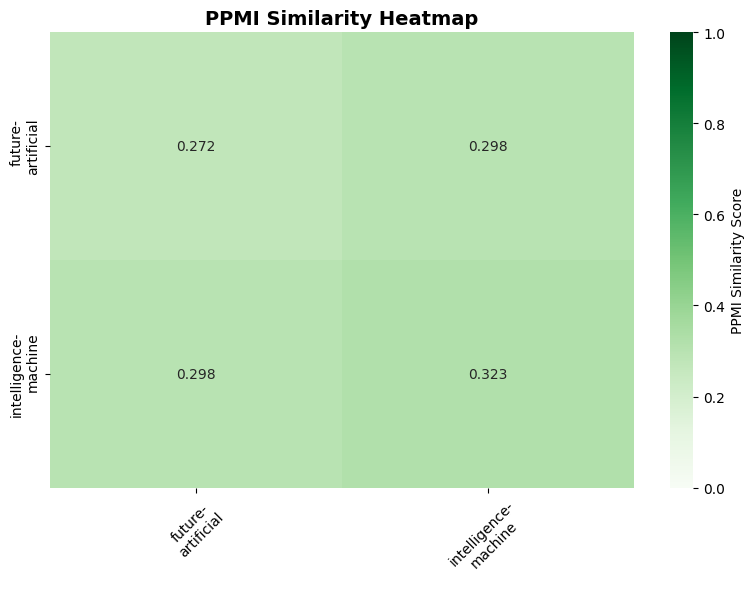

In [ ]:
#Heatmap Analysis for PPMI
ppmi_similarities = [word_pair_result2[pair]['ppmi'] for pair in word_pairs2]

similarity_matrix = np.zeros((len(word_pairs2), len(word_pairs2)))
for i in range(len(word_pairs2)):
    for j in range(len(word_pairs2)):
        if i == j:
            similarity_matrix[i, j] = ppmi_similarities[i]
        else:
            similarity_matrix[i, j] = (ppmi_similarities[i] + ppmi_similarities[j]) / 2

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix,
            xticklabels=pair_labels2,
            yticklabels=pair_labels2,
            annot=True,
            fmt='.3f',
            cmap='Greens',
            cbar_kws={'label': 'PPMI Similarity Score'},
            vmin=0, vmax=1)
plt.title('PPMI Similarity Heatmap Word Pairs 2', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

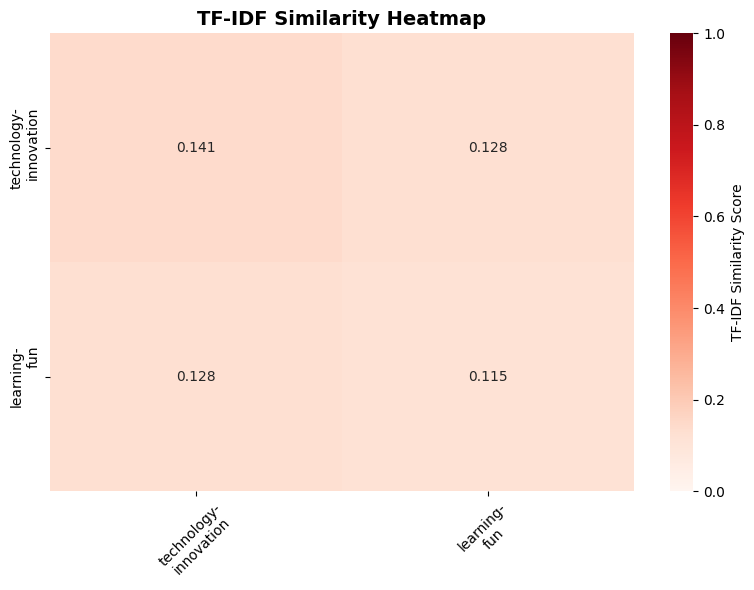

In [ ]:
#Heatmap Analysis for TF-IDF
tfidf_similarities = [word_pair_result1[pair]['tfidf'] for pair in word_pairs1]

similarity_matrix = np.zeros((len(word_pairs1), len(word_pairs1)))
for i in range(len(word_pairs1)):
    for j in range(len(word_pairs1)):
        if i == j:
            similarity_matrix[i, j] = tfidf_similarities[i]
        else:
            similarity_matrix[i, j] = (tfidf_similarities[i] + tfidf_similarities[j]) / 2

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix,
            xticklabels=pair_labels1,
            yticklabels=pair_labels1,
            annot=True,
            fmt='.3f',
            cmap='Reds',
            cbar_kws={'label': 'TF-IDF Similarity Score'},
            vmin=0, vmax=1)
plt.title('TF-IDF Similarity Heatmap Word Pairs 1', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

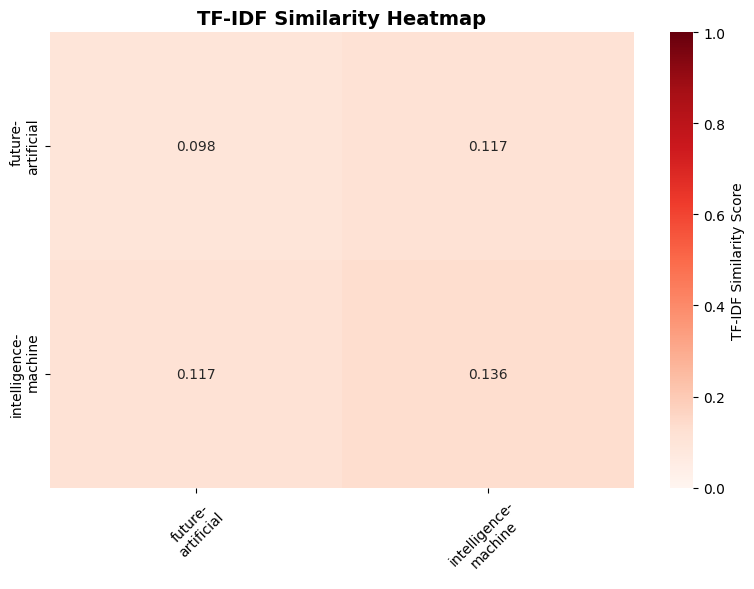

In [ ]:
tfidf_similarities = [word_pair_result2[pair]['tfidf'] for pair in word_pairs2]

similarity_matrix = np.zeros((len(word_pairs2), len(word_pairs2)))
for i in range(len(word_pairs2)):
    for j in range(len(word_pairs2)):
        if i == j:
            similarity_matrix[i, j] = tfidf_similarities[i]
        else:
            similarity_matrix[i, j] = (tfidf_similarities[i] + tfidf_similarities[j]) / 2

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix,
            xticklabels=pair_labels2,
            yticklabels=pair_labels2,
            annot=True,
            fmt='.3f',
            cmap='Reds',
            cbar_kws={'label': 'TF-IDF Similarity Score'},
            vmin=0, vmax=1)
plt.title('TF-IDF Similarity Heatmap Word Pairs 2', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Analysis from Heatmap

It seems like the PPMI model works the best out of all the 